In [1]:
%matplotlib inline
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt

# Cross-check of "real" neighbors vs neighbors found with filter reshift
For doing this validation, we take the validation set and pass it through Phosphoros fixing the real redshift. This will give us the best matching
SED, so we can re-compute a "centered" photometry (**no shifts**).

We run NNPZ over this recomputed photometries, assuming this will give us the "real" neighbors of this object.

On a second pass, we run NNPZ over the original test test (**with shifts**). We then compare how many of the "real" neighbors were actually picked.

## Input catalogs

In [2]:
best_case = Table.read('/home/aalvarez/Work/Data/WillHartley/NNPZ_run_recomputed.fits', hdu=1)
shifted_case = Table.read('/home/aalvarez/Work/Data/WillHartley/NNPZ_run_shifts.fits', hdu=1)
sample = Table.read('/home/aalvarez/Work/Data/WillHartley/Sample.fits')

In [3]:
np.all(best_case['ID'] == shifted_case['ID'])

True

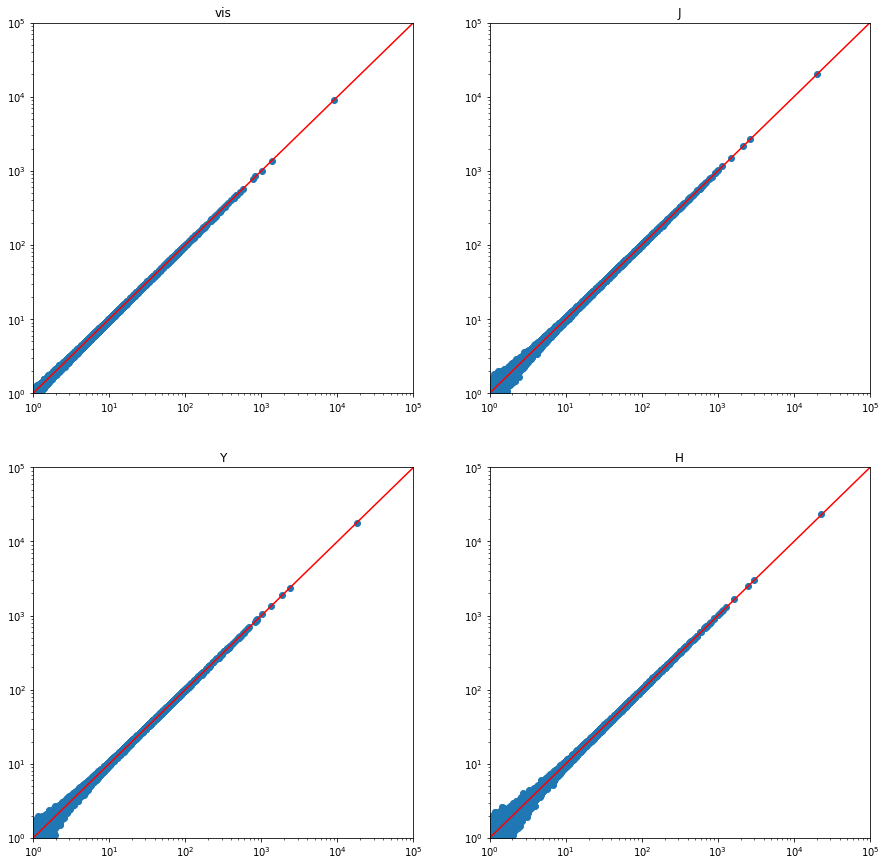

In [4]:
# Fluxes have been recomputed, so they will not be exactly the same, but I want to verify they look like the same sources at least
fig, axes = plt.subplots(2,2,figsize=(15,15))
for i, band in enumerate(['vis', 'Y', 'J', 'H']):
    x = i % 2
    y = i // 2
    axes[x,y].scatter(best_case['Flux_{}'.format(band)], shifted_case['Flux_{}'.format(band)])
    axes[x,y].plot([0, 1e5], [0, 1e5], c='r')
    axes[x,y].set_xscale('log')
    axes[x,y].set_yscale('log')
    axes[x,y].set_xlim(1, 1e5)
    axes[x,y].set_ylim(1, 1e5)
    axes[x,y].set_title(band)
plt.show()

The above plot is just to make sure that the recomputed photometries look "reasonable"

## SpecZ vs PhotoZ

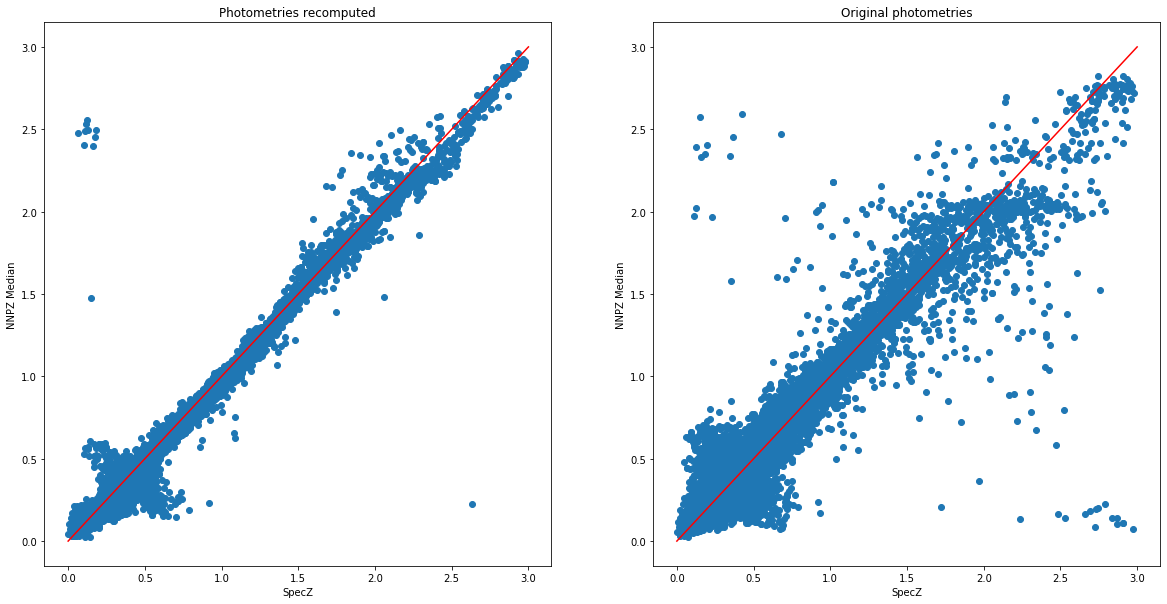

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].scatter(sample['z'], best_case['REDSHIFT_MEDIAN'])
axes[0].set_title('Photometries recomputed')
axes[0].plot([0, 3], [0,3], c='r')
axes[0].set_xlabel('SpecZ')
axes[0].set_ylabel('NNPZ Median')

axes[1].scatter(sample['z'], shifted_case['REDSHIFT_MEDIAN'])
axes[1].set_title('Original photometries')
axes[1].plot([0, 3], [0,3], c='r')
axes[1].set_xlabel('SpecZ')
axes[1].set_ylabel('NNPZ Median')

plt.show()

For the recomputed photometries, there is less scatter, as it would be expected.

# Compare best neighbors in ideal scenario, with best neighbors in shifted one

In [6]:
def first_nonzero(arr, axis, invalid_val=-1):
    mask = arr!=0
    return np.where(mask.any(axis=axis), mask.argmax(axis=axis), invalid_val)

In [7]:
best_sorted = np.take_along_axis(best_case['NEIGHBOR_IDS'], np.flip(np.argsort(best_case['NEIGHBOR_WEIGHTS'])), axis=-1)

In [8]:
shift_sorted = np.take_along_axis(shifted_case['NEIGHBOR_IDS'], np.flip(np.argsort(shifted_case['NEIGHBOR_WEIGHTS'])), axis=-1)

In [9]:
matches = first_nonzero(best_sorted - shift_sorted, axis=-1, invalid_val=best_sorted.shape[1])

In [10]:
bins = np.arange(-0.5, 30.6, 1)

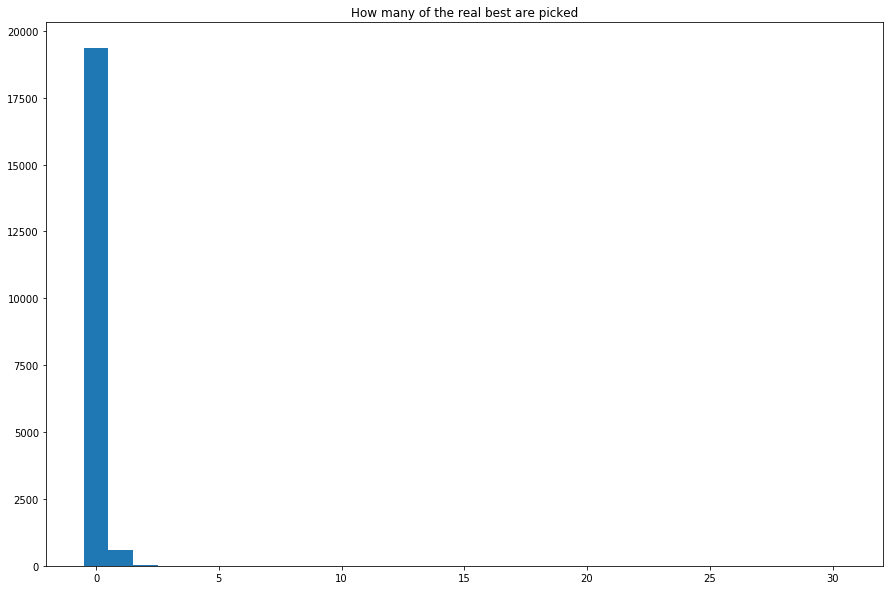

In [11]:
plt.figure(figsize=(15,10))
plt.hist(matches, bins=bins)
plt.title('How many of the real best are picked')
plt.show()

Most sources miss **all** the neighbors that were picked when the photometries were computed using the reference filter transmission.

In [12]:
best_ids_sorted = np.flip(np.sort(best_case['NEIGHBOR_IDS']))
shifted_ids_sorted = np.flip(np.sort(shifted_case['NEIGHBOR_IDS']))

In [13]:
match_ids = first_nonzero(best_ids_sorted - shifted_ids_sorted, axis=-1, invalid_val=-1)+1

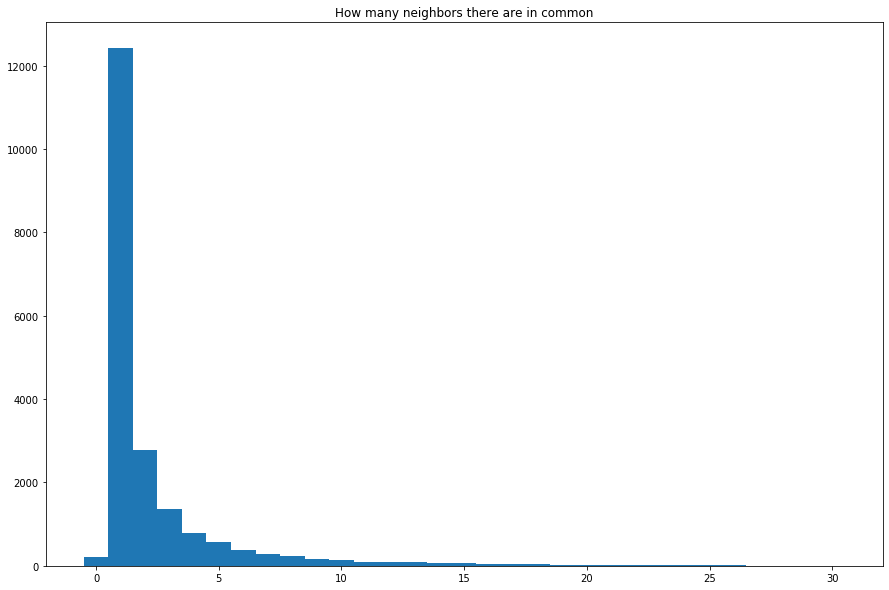

In [14]:
plt.figure(figsize=(15,10))
plt.title('How many neighbors there are in common')
plt.hist(match_ids, bins=bins)
plt.show()

Most sources only have a handful of neighbors in common.

This likely mean that NNPZ already misses most good neighbors during the first stages - search in Euclidean and search with $\chi^2$.
Recomputing the photometries for the weights can not fix the fact that the samples we have are not good enough.